In [1]:
import numpy as np
import json
import time
from pathlib import Path
from scipy.optimize import minimize
import matplotlib.pyplot as plt

## Definicion de la funcion objetivo y su gradiente.

In [2]:
def f(x):
    """Objective function"""
    x_val, y_val = x[0], x[1]
    return -(np.arctan(x_val + y_val + 1) + 
             np.arctan(x_val - y_val + 2) + 
             np.arctan(-x_val - y_val + 3) + 
             np.arctan(-x_val + y_val + 4))

def grad_f(x):
    """Gradient of objective function"""
    x_val, y_val = x[0], x[1]
    u1 = x_val + y_val + 1
    u2 = x_val - y_val + 2
    u3 = -x_val - y_val + 3
    u4 = -x_val + y_val + 4
    
    df_dx = -1/(1 + u1**2) - 1/(1 + u2**2) + 1/(1 + u3**2) + 1/(1 + u4**2)
    df_dy = -1/(1 + u1**2) + 1/(1 + u2**2) + 1/(1 + u3**2) - 1/(1 + u4**2)
    
    return np.array([df_dx, df_dy])

## Implementacion de los algoritmos

In [3]:
def gradient_descent(x0, learning_rate, tol, max_iter):
    """Gradient Descent optimization"""
    x = np.array(x0, dtype=float)
    history = [x.copy()]
    
    for i in range(max_iter):
        grad = grad_f(x)
        x_new = x - learning_rate * grad
        history.append(x_new.copy())
        
        if np.linalg.norm(x_new - x) < tol:
            return x_new, i + 1, history
        
        x = x_new
    
    return x, max_iter, history

def bfgs_method(x0, tol, max_iter):
    """BFGS Quasi-Newton optimization"""
    history = [np.array(x0)]
    
    def callback(xk):
        history.append(xk.copy())
    
    result = minimize(f, x0, method='BFGS', jac=grad_f, 
                     options={'maxiter': max_iter, 'gtol': tol},
                     callback=callback)
    
    return result.x, result.nit, history

## Definir metodo para hacer experimentos

In [4]:
def MakeExperiments():
    """Load configs, run experiments, save results"""
    exp_dir = Path('Experiments')
    results_dir = Path('Results')
    results_dir.mkdir(exist_ok=True)
    
    for exp_file in exp_dir.glob('*.json'):
        with open(exp_file, 'r') as fh:
            configs = json.load(fh)
        
        results = []
        
        for config in configs:
            lr = config['learning_rate']
            tol = config['tol']
            max_iter = config['max_iter']
            x0 = config['x0']
            
            # Gradient Descent
            start = time.time()
            x_gd, iter_gd, hist_gd = gradient_descent(x0, lr, tol, max_iter)
            time_gd = time.time() - start
            
            # BFGS
            start = time.time()
            x_bfgs, iter_bfgs, hist_bfgs = bfgs_method(x0, tol, max_iter)
            time_bfgs = time.time() - start
            results.append({
                'config': config,
                'gradient_descent': {
                    'solution': x_gd.tolist(),
                    'f_value': float(f(x_gd)),
                    'iterations': int(iter_gd),
                    'time': float(time_gd),
                    'gradient_norm': float(np.linalg.norm(grad_f(x_gd))),
                    'path': [pt.tolist() for pt in hist_gd]
                },
                'bfgs': {
                    'solution': x_bfgs.tolist(),
                    'f_value': float(f(x_bfgs)),
                    'iterations': int(iter_bfgs),
                    'time': float(time_bfgs),
                    'gradient_norm': float(np.linalg.norm(grad_f(x_bfgs))),
                    'path': [pt.tolist() for pt in hist_bfgs]
                }
            })
        
        result_file = results_dir / f'results_{exp_file.name}'
        with open(result_file, 'w') as fh:
            json.dump(results, fh, indent=2)
        
        print(f"Results saved to {result_file}")
    
    return results

## Ejecutar y guardar resultados de lso experimentos

In [5]:
results = MakeExperiments()

Results saved to Results\results_curated_exp.json
Results saved to Results\results_exp1.json


## Algunas estadisticas relevantes de los experimentos

In [6]:
import json
import numpy as np

with open('./Results/results_exp1.json') as fh:
    data = json.load(fh)

gd_times = [r['gradient_descent']['time'] for r in data]
bfgs_times = [r['bfgs']['time'] for r in data]

print(f"Average time: GD={np.mean(gd_times):.4f}s, BFGS={np.mean(bfgs_times):.4f}s")
print(f"""Success rate: GD={sum(1 for r in data if r['gradient_descent']['gradient_norm'] < r['config']['tol'])/len(data):.1%},
            BFGS={sum(1 for r in data if r['bfgs']['gradient_norm'] < r['config']['tol'])/len(data):.1%}""")
print(f"Avg iterations: GD={np.mean([r['gradient_descent']['iterations'] for r in data]):.0f}, BFGS={np.mean([r['bfgs']['iterations'] for r in data]):.0f}")
print(f"Time ratio BFGS/GD: {np.mean(bfgs_times)/np.mean(gd_times):.2f}x")
print(f"Convergence reliability: GD={sum(1 for r in data if r['gradient_descent']['gradient_norm'] < r['config']['tol'])/len(data):.1%}, BFGS={sum(1 for r in data if r['bfgs']['gradient_norm'] < r['config']['tol'])/len(data):.1%}")

Average time: GD=0.0715s, BFGS=0.0059s
Success rate: GD=13.0%,
            BFGS=94.3%
Avg iterations: GD=3611, BFGS=9
Time ratio BFGS/GD: 0.08x
Convergence reliability: GD=13.0%, BFGS=94.3%


## Algunos gráficos comparativos de las soluciones encontradas por los algoritmos

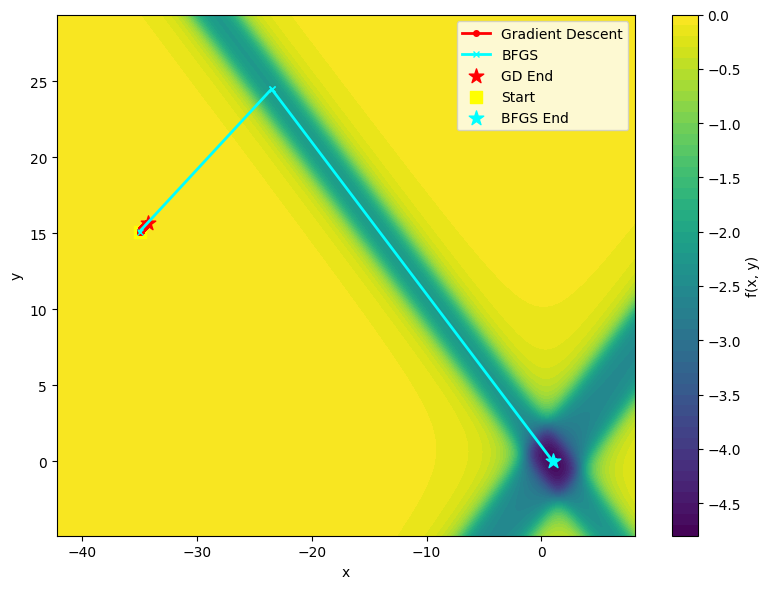

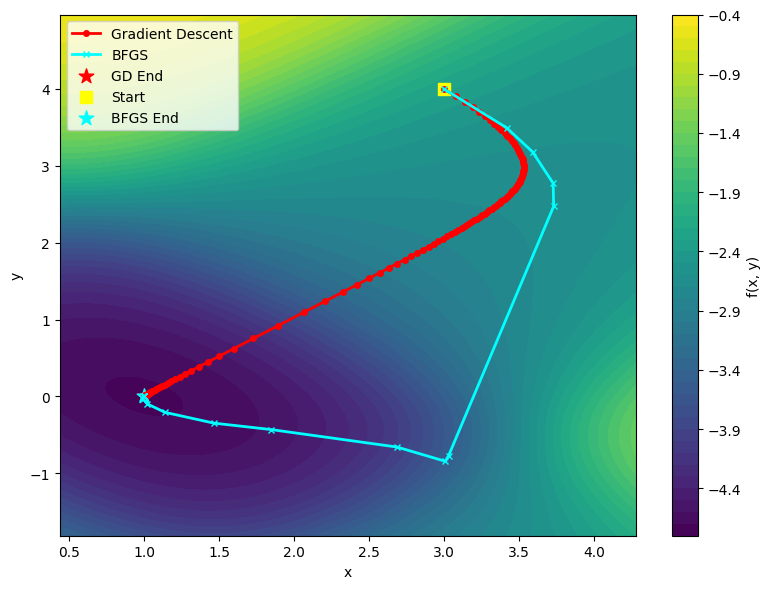

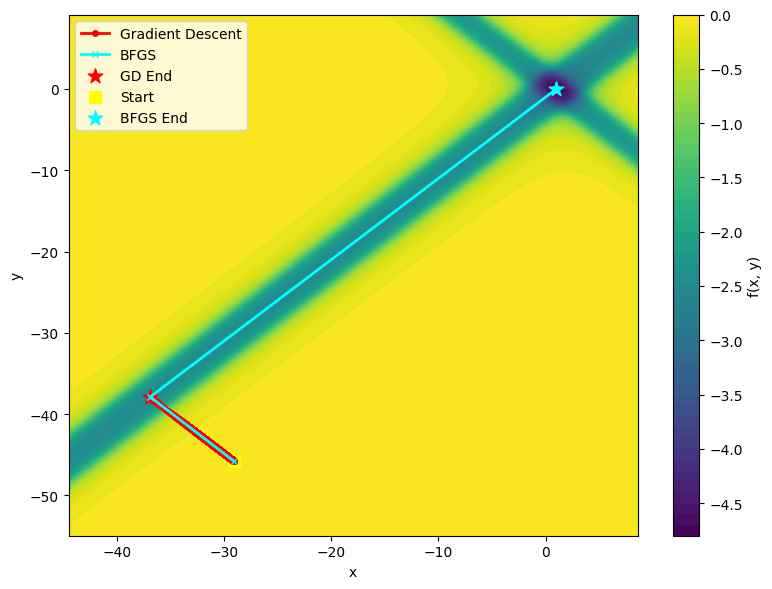

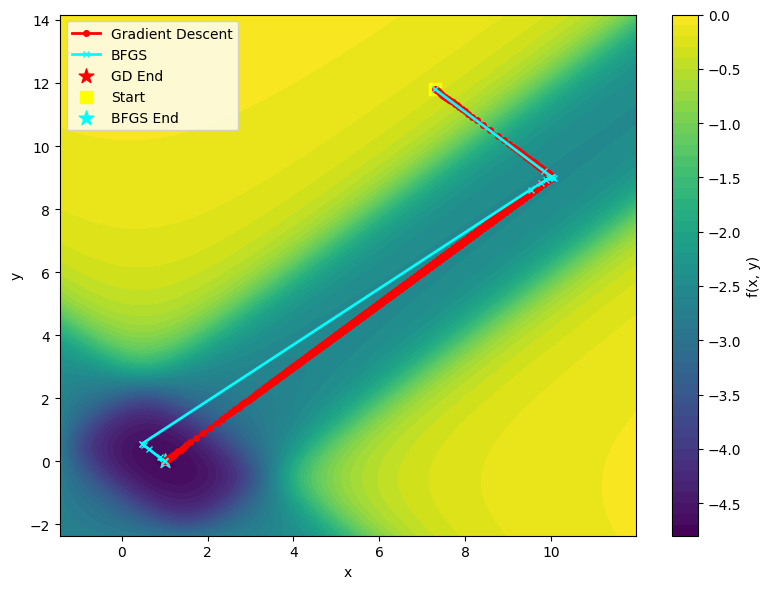

In [7]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np


with open('./Results/results_curated_exp.json', 'r') as fh:
    exp_results = json.load(fh)

for idx, result in enumerate(exp_results):
    # Extract paths
    path_gd = np.array(result['gradient_descent']['path'])
    path_bfgs = np.array(result['bfgs']['path'])
        
    # Calculate dynamic range from experiment results
    all_points = np.vstack([path_gd, path_bfgs])
    x_min, x_max = all_points[:, 0].min(), all_points[:, 0].max()
    y_min, y_max = all_points[:, 1].min(), all_points[:, 1].max()
        
    # Add padding
    x_padding = (x_max - x_min) * 0.2
    y_padding = (y_max - y_min) * 0.2
    x_min -= x_padding
    x_max += x_padding
    y_min -= y_padding
    y_max += y_padding
        
    # Create grid based on dynamic range
    grid_points = 200
    x = np.linspace(x_min, x_max, grid_points)
    y = np.linspace(y_min, y_max, grid_points)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)
        
    # Compute function values
    for i in range(grid_points):
        for j in range(grid_points):
            Z[i, j] = f([X[i, j], Y[i, j]])
        
    # Plot
    plt.figure(figsize=(8, 6))
    plt.contourf(X, Y, Z, levels=50, cmap='viridis')
    plt.colorbar(label='f(x, y)')
    plt.plot(path_gd[:, 0], path_gd[:, 1], marker='o', color='red', label='Gradient Descent', linewidth=2, markersize=4)
    plt.plot(path_bfgs[:, 0], path_bfgs[:, 1], marker='x', color='cyan', label='BFGS', linewidth=2, markersize=4)
    plt.scatter(path_gd[-1, 0], path_gd[-1, 1], color='red', marker='*', s=120, label='GD End')
    plt.scatter(path_bfgs[0, 0], path_bfgs[0, 1], color='yellow', marker='s', s=80, label='Start')
    plt.scatter(path_bfgs[-1, 0], path_bfgs[-1, 1], color='cyan', marker='*', s=120, label='BFGS End')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

## Gráfica comparativas de las iteraciones y el tiempo transcurrido en la ejecución de los algoritmos

In [8]:
import os
import json
import webbrowser
import tempfile
import plotly.graph_objects as go
from plotly.subplots import make_subplots

results_dir = 'Results'
result_files = [f for f in os.listdir(results_dir) if f.startswith('results_') and f.endswith('.json')]

for file_idx, result_file in enumerate(sorted(result_files)):
    with open(os.path.join(results_dir, result_file), 'r') as fh:
        exp_results = json.load(fh)
    
    iterations_gd = [r['gradient_descent']['iterations'] for r in exp_results]
    iterations_bfgs = [r['bfgs']['iterations'] for r in exp_results]
    times_gd = [r['gradient_descent']['time'] for r in exp_results]
    times_bfgs = [r['bfgs']['time'] for r in exp_results]
    x_pos = list(range(len(exp_results)))
    x_labels = [str(i+1) for i in x_pos]
    
    fig = make_subplots(rows=1, cols=2, 
                       subplot_titles=('Iterations Comparison', 'Time Comparison (s)'))
    
    # Iterations plot
    fig.add_trace(go.Scatter(x=x_labels, y=iterations_gd, 
                            fill='tozeroy', mode='lines+markers',
                            name='Gradient Descent', line=dict(color='red'),
                            marker=dict(symbol='circle')), row=1, col=1)
    
    fig.add_trace(go.Scatter(x=x_labels, y=iterations_bfgs, 
                            fill='tozeroy', mode='lines+markers', 
                            name='BFGS', line=dict(color='cyan'),
                            marker=dict(symbol='x')), row=1, col=1)
    
    # Time plot
    fig.add_trace(go.Scatter(x=x_labels, y=times_gd, 
                            fill='tozeroy', mode='lines+markers',
                            name='Gradient Descent', line=dict(color='red'),
                            marker=dict(symbol='circle'), showlegend=False), row=1, col=2)
    
    fig.add_trace(go.Scatter(x=x_labels, y=times_bfgs, 
                            fill='tozeroy', mode='lines+markers',
                            name='BFGS', line=dict(color='cyan'),
                            marker=dict(symbol='x'), showlegend=False), row=1, col=2)
    
    fig.update_xaxes(title_text="Experiment", row=1, col=1)
    fig.update_xaxes(title_text="Experiment", row=1, col=2)
    fig.update_yaxes(title_text="Iterations", row=1, col=1)
    fig.update_yaxes(title_text="Time (s)", row=1, col=2)
    
    fig.update_layout(title_text=f'Experiment Set {file_idx+1}: {result_file}',
                     height=500, width=1000)
    
    # Save to temporary file and open automatically
    with tempfile.NamedTemporaryFile(mode='w', suffix='.html', delete=False, prefix=f'plot_{file_idx}_') as tmp:
        fig.write_html(tmp.name)
        webbrowser.open('file://' + tmp.name)
        print(f"Opened plot: {tmp.name}")

Opened plot: C:\Users\PC\AppData\Local\Temp\plot_0__lcwx4qw.html
Opened plot: C:\Users\PC\AppData\Local\Temp\plot_1_eef35w6v.html
